In [20]:
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import random
import pandas as pd
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import os

In [15]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS': 40,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':64,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

In [37]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU 1 to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [40]:
df = pd.read_csv('/home/jang346/workplace/dacon_ocr/train.csv')

In [41]:
df['img_path'] = df['img_path'].apply(lambda x : x[:2] + 'data/' + x[2:])
df['len'] = df['label'].str.len()
df = df[df['len']==1]

In [45]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df, test_size = 0.2, shuffle=True)

In [36]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        # image = Image.open(self.img_path_list[index]).convert('RGB')
        image = cv2.imread(self.img_path_list[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.train_mode:
            image = self.train_transform(image)['image'].type(torch.FloatTensor)
        else:
            image = self.test_transform(image)['image'].type(torch.FloatTensor)
            
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = A.Compose([
            A.Resize(height = CFG['IMG_HEIGHT_SIZE'], width = 64),
            # A.Rotate(limit=7, p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
        return transform_ops(image = image)
    
    def test_transform(self, image):
        transform_ops = A.Compose([
            A.Resize(height = CFG['IMG_HEIGHT_SIZE'], width = CFG['IMG_WIDTH_SIZE']),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
        return transform_ops(image = image)

In [48]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values)
train_data_loader  = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

test_dataset = CustomDataset(test['img_path'].values, test['label'].values)
test_data_loader  = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


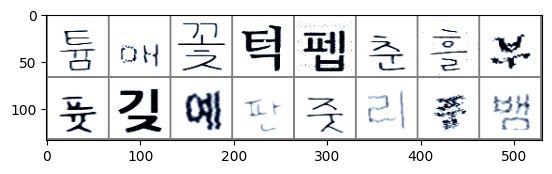

In [49]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

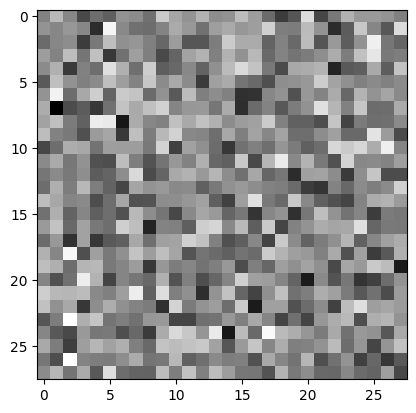

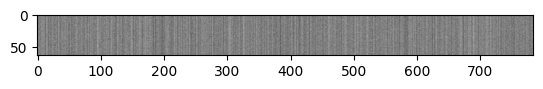

In [50]:
d_noise  = 100
d_hidden = 256
batch_size =64

def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [51]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([64, 784])
torch.Size([64, 1])
tensor([[0.4911, 0.4879, 0.4906, 0.4915, 0.4887]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [58]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):

    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:

        # img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #

        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #

        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()

        # Update parameters
        _optimizer_g.step()

def evaluate_model(generator, discriminator):

    p_real, p_fake = 0.,0.

    generator.eval()
    discriminator.eval()

    for img_batch, label_batch in test_data_loader:

        # img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.


    return p_real, p_fake

In [59]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):

    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    if((epoch+1)% 50 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

RuntimeError: shape '[-1, 784]' is invalid for input of size 786432